# Monte Carlo - Variance Reduction Technique
Simple code to show MC with Control Variates

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple


def european_call_mc(
        s0: float,
        K: float,
        r: float,
        q: float,
        sigma: float,
        T: float,
        n: int,
        seed: int = 0) -> Tuple[float, np.ndarray]:
    
    rng = np.random.default_rng(seed=seed)
    Z = rng.standard_normal(size=n)
    ST = s0 * np.exp((r - q - 0.5 * sigma * sigma) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0.0)
    price = np.exp(-r * T) * payoff.mean()
    return price , payoff


def european_call_mc_control(
        s0: float,
        K: float,
        r: float,
        q: float,
        sigma: float,
        T: float,
        n: int,
        seed: int = 0) -> Tuple[float, np.ndarray]:
    
    rng = np.random.default_rng(seed)
    Z = rng.standard_normal(n)

    # As control variate:
    # Let's use Y = exp^(-rT)S_T
    # E[Y] = exp^(-rT)E[S_T] = exp^(-rT)S_texp^(r-q) = exp^(-qT)S_t
    
    ST = s0 * np.exp((r - q - 0.5 * sigma * sigma) * T + sigma * np.sqrt(T) * Z)
    discounted_payoff = np.exp(-r * T) * np.maximum(ST - K, 0.0)  # Discounted
    control = np.exp((- r *T)) * ST # Discounted

    beta = np.cov(discounted_payoff, control, ddof=1)[0,1] / np.var(control,ddof=1)
    correlation = np.corrcoef(discounted_payoff, control)[0,1]

    expected_value_y= s0 * np.exp((- q *T))
    adjusted_discounted_payoff = discounted_payoff - beta * (control - expected_value_y )
    price = adjusted_discounted_payoff.mean()

    return price, adjusted_discounted_payoff, beta, correlation

In [20]:
# Parameters for Option

# Option details
K, r, q, sigma, T = 100, 0.05, 0.0, 0.2, 1.0

s0_otm = 50
s0_atm = 100
s0_itm = 150

# Run multiple seeds to see variability
n_runs: int = 100

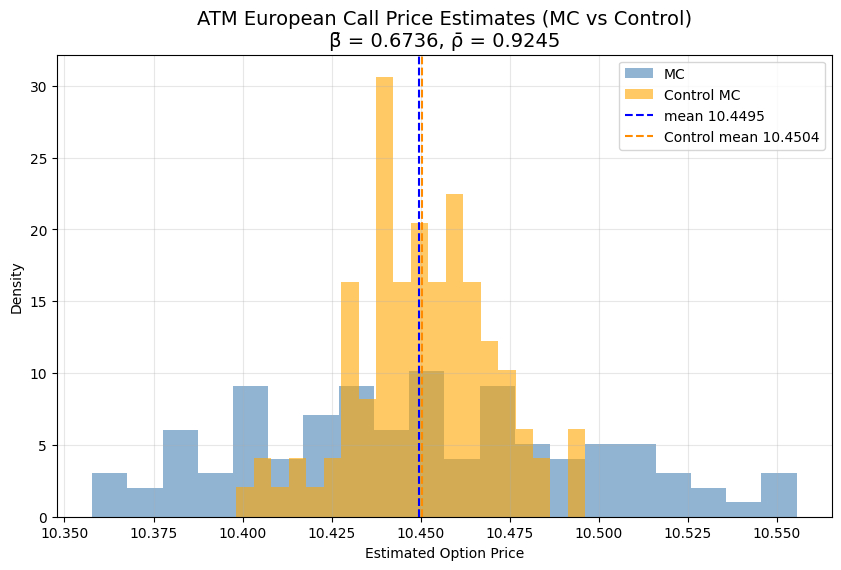

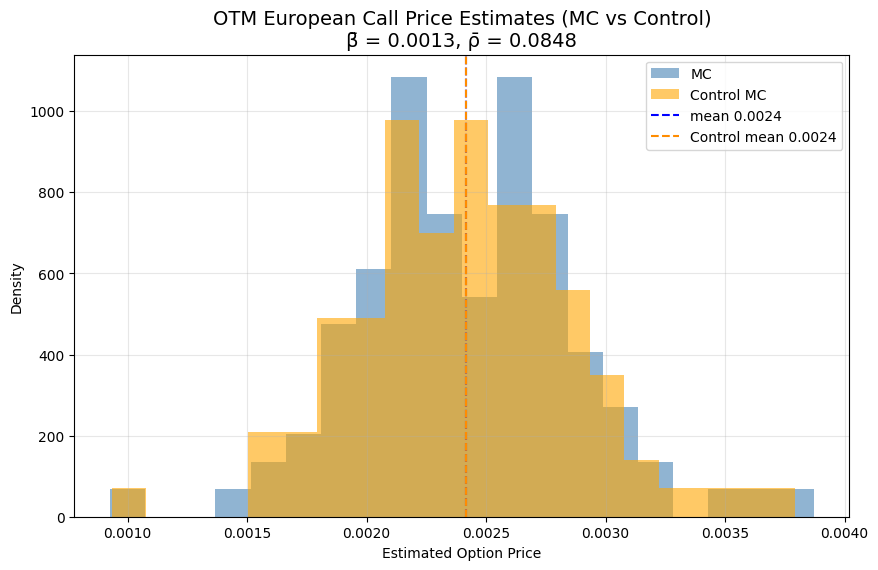

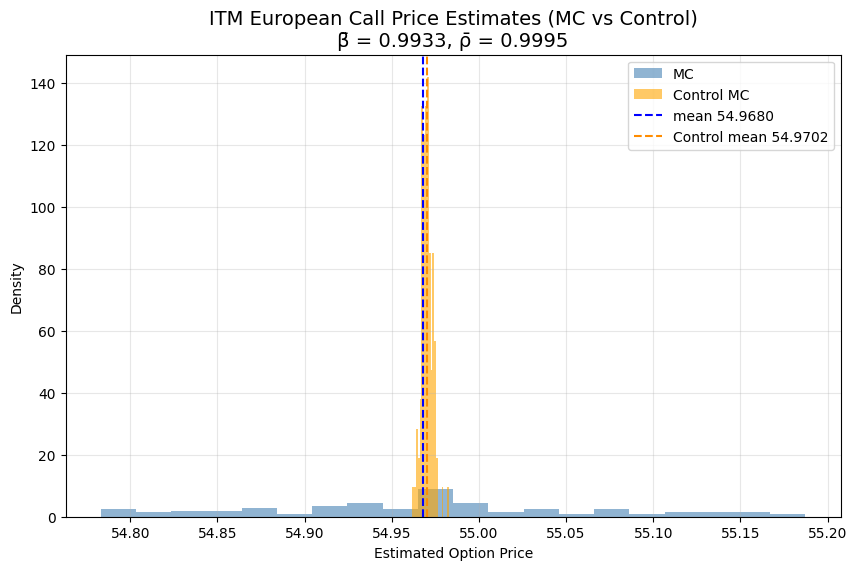

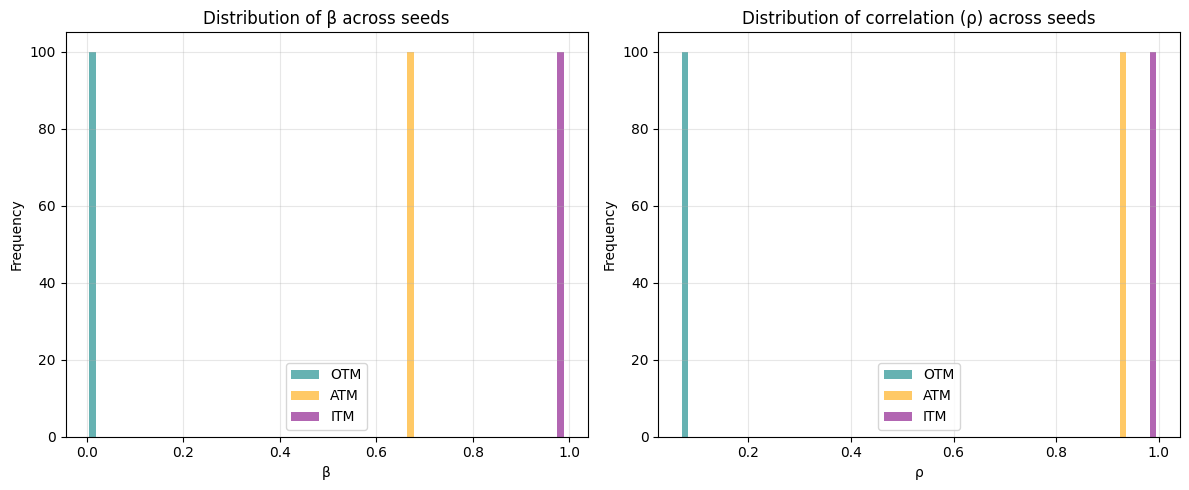

In [ ]:
# --- Number of paths ---
n_paths: int = 100_000

# Containers for results
mc_estimates_otm, mc_control_estimates_otm, betas_otm, rhos_otm = [], [], [], []
mc_estimates_atm, mc_control_estimates_atm, betas_atm, rhos_atm = [], [], [], []
mc_estimates_itm, mc_control_estimates_itm, betas_itm, rhos_itm = [], [], [], []

# --- Run all seeds ---
for seed in range(n_runs):
    # OTM
    mc_estimates_otm.append(european_call_mc(s0_otm, K, r, q, sigma, T, n_paths, seed)[0])
    price_cv, _, beta, rho = european_call_mc_control(s0_otm, K, r, q, sigma, T, n_paths, seed)
    mc_control_estimates_otm.append(price_cv)
    betas_otm.append(beta)
    rhos_otm.append(rho)

    # ATM
    mc_estimates_atm.append(european_call_mc(s0_atm, K, r, q, sigma, T, n_paths, seed)[0])
    price_cv, _, beta, rho = european_call_mc_control(s0_atm, K, r, q, sigma, T, n_paths, seed)
    mc_control_estimates_atm.append(price_cv)
    betas_atm.append(beta)
    rhos_atm.append(rho)

    # ITM
    mc_estimates_itm.append(european_call_mc(s0_itm, K, r, q, sigma, T, n_paths, seed)[0])
    price_cv, _, beta, rho = european_call_mc_control(s0_itm, K, r, q, sigma, T, n_paths, seed)
    mc_control_estimates_itm.append(price_cv)
    betas_itm.append(beta)
    rhos_itm.append(rho)

# Convert to arrays
mc_estimates_otm, mc_control_estimates_otm = np.array(mc_estimates_otm), np.array(mc_control_estimates_otm)
mc_estimates_atm, mc_control_estimates_atm = np.array(mc_estimates_atm), np.array(mc_control_estimates_atm)
mc_estimates_itm, mc_control_estimates_itm = np.array(mc_estimates_itm), np.array(mc_control_estimates_itm)

# Compute average β and ρ
beta_otm, rho_otm = np.mean(betas_otm), np.mean(rhos_otm)
beta_atm, rho_atm = np.mean(betas_atm), np.mean(rhos_atm)
beta_itm, rho_itm = np.mean(betas_itm), np.mean(rhos_itm)

# --- Plot distributions of estimates for ATM ---
plt.figure(figsize=(10, 6))
plt.hist(mc_estimates_atm, bins=20, alpha=0.6, label="MC", density=True, color="steelblue")
plt.hist(mc_control_estimates_atm, bins=20, alpha=0.6, label="Control MC", density=True, color="orange")
plt.axvline(np.mean(mc_estimates_atm), color="blue", linestyle="--", label=f"mean {np.mean(mc_estimates_atm):.4f}")
plt.axvline(np.mean(mc_control_estimates_atm), color="darkorange", linestyle="--", label=f"Control mean {np.mean(mc_control_estimates_atm):.4f}")
plt.title(f"ATM European Call Price Estimates (MC vs Control)\nβ̄ = {beta_atm:.4f}, ρ̄ = {rho_atm:.4f}", fontsize=14)
plt.xlabel("Estimated Option Price")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Plot distributions of estimates for OTM ---
plt.figure(figsize=(10, 6))
plt.hist(mc_estimates_otm, bins=20, alpha=0.6, label="MC", density=True, color="steelblue")
plt.hist(mc_control_estimates_otm, bins=20, alpha=0.6, label="Control MC", density=True, color="orange")
plt.axvline(np.mean(mc_estimates_otm), color="blue", linestyle="--", label=f"mean {np.mean(mc_estimates_otm):.4f}")
plt.axvline(np.mean(mc_control_estimates_otm), color="darkorange", linestyle="--", label=f"Control mean {np.mean(mc_control_estimates_otm):.4f}")
plt.title(f"OTM European Call Price Estimates (MC vs Control)\nβ̄ = {beta_otm:.4f}, ρ̄ = {rho_otm:.4f}", fontsize=14)
plt.xlabel("Estimated Option Price")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Plot distributions of estimates for ITM ---
plt.figure(figsize=(10, 6))
plt.hist(mc_estimates_itm, bins=20, alpha=0.6, label="MC", density=True, color="steelblue")
plt.hist(mc_control_estimates_itm, bins=20, alpha=0.6, label="Control MC", density=True, color="orange")
plt.axvline(np.mean(mc_estimates_itm), color="blue", linestyle="--", label=f"mean {np.mean(mc_estimates_itm):.4f}")
plt.axvline(np.mean(mc_control_estimates_itm), color="darkorange", linestyle="--", label=f"Control mean {np.mean(mc_control_estimates_itm):.4f}")
plt.title(f"ITM European Call Price Estimates (MC vs Control)\nβ̄ = {beta_itm:.4f}, ρ̄ = {rho_itm:.4f}", fontsize=14)
plt.xlabel("Estimated Option Price")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Plot distribution of β and ρ across seeds ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist([betas_otm, betas_atm, betas_itm], bins=20, label=["OTM", "ATM", "ITM"], color=["teal", "orange", "purple"], alpha=0.6)
axs[0].set_title("Distribution of β across seeds")
axs[0].set_xlabel("β")
axs[0].set_ylabel("Frequency")
axs[0].legend()
axs[0].grid(alpha=0.3)

axs[1].hist([rhos_otm, rhos_atm, rhos_itm], bins=20, label=["OTM", "ATM", "ITM"], color=["teal", "orange", "purple"], alpha=0.6)
axs[1].set_title("Distribution of correlation (ρ) across seeds")
axs[1].set_xlabel("ρ")
axs[1].set_ylabel("Frequency")
axs[1].legend()
axs[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()


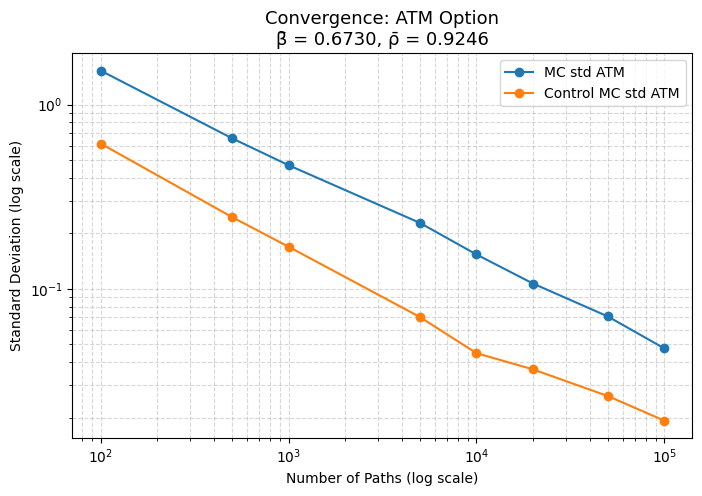

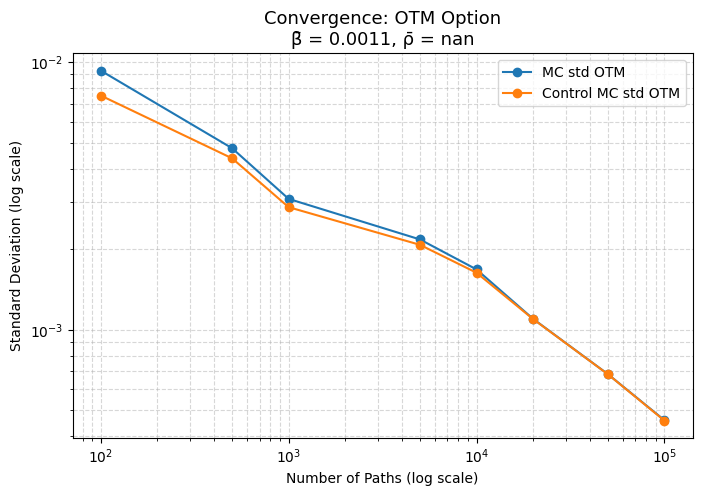

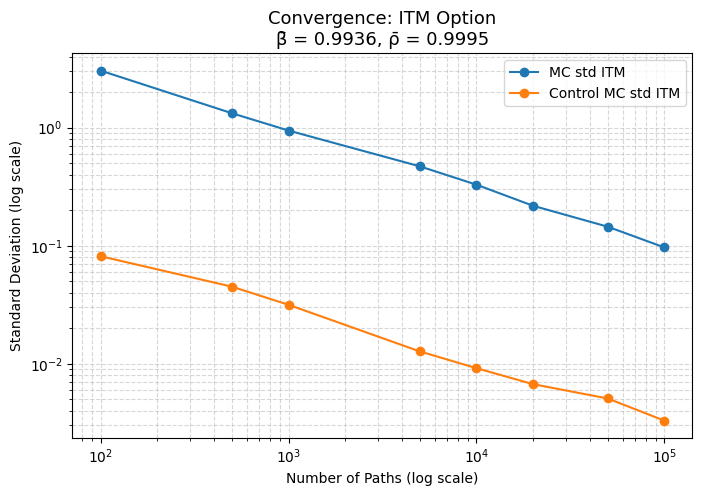

In [35]:
path_list = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000]

# Store stds for each moneyness
mc_std_otm, mc_control_std_otm = [], []
mc_std_atm, mc_control_std_atm = [], []
mc_std_itm, mc_control_std_itm = [], []

# Store average β and ρ
beta_otm, beta_atm, beta_itm = [], [], []
rho_otm, rho_atm, rho_itm = [], [], []

for n_paths in path_list:
    seeds = np.arange(n_runs)

    # --- OTM ---
    mc_estimates_otm, mc_control_estimates_otm = [], []
    betas_tmp_otm, rhos_tmp_otm = [], []
    for seed in seeds:
        mc_estimates_otm.append(european_call_mc(s0_otm, K, r, q, sigma, T, n_paths, seed)[0])
        price_cv_otm, _, beta, rho = european_call_mc_control(s0_otm, K, r, q, sigma, T, n_paths, seed)
        mc_control_estimates_otm.append(price_cv_otm)
        betas_tmp_otm.append(beta)
        rhos_tmp_otm.append(rho)
    mc_std_otm.append(np.std(mc_estimates_otm))
    mc_control_std_otm.append(np.std(mc_control_estimates_otm))
    beta_otm.append(np.mean(betas_tmp_otm))
    rho_otm.append(np.mean(rhos_tmp_otm))

    # --- ATM ---
    mc_estimates_atm, mc_control_estimates_atm = [], []
    betas_tmp, rhos_tmp = [], []
    for seed in seeds:
        mc_estimates_atm.append(european_call_mc(s0_atm, K, r, q, sigma, T, n_paths, seed)[0])
        price_cv_atm, _, beta, rho = european_call_mc_control(s0_atm, K, r, q, sigma, T, n_paths, seed)
        mc_control_estimates_atm.append(price_cv_atm)
        betas_tmp.append(beta)
        rhos_tmp.append(rho)
    mc_std_atm.append(np.std(mc_estimates_atm))
    mc_control_std_atm.append(np.std(mc_control_estimates_atm))
    beta_atm.append(np.mean(betas_tmp))
    rho_atm.append(np.mean(rhos_tmp))

    # --- ITM ---
    mc_estimates_itm, mc_control_estimates_itm = [], []
    betas_tmp, rhos_tmp = [], []
    for seed in seeds:
        mc_estimates_itm.append(european_call_mc(s0_itm, K, r, q, sigma, T, n_paths, seed)[0])
        price_cv_itm, _, beta, rho = european_call_mc_control(s0_itm, K, r, q, sigma, T, n_paths, seed)
        mc_control_estimates_itm.append(price_cv_itm)
        betas_tmp.append(beta)
        rhos_tmp.append(rho)
    mc_std_itm.append(np.std(mc_estimates_itm))
    mc_control_std_itm.append(np.std(mc_control_estimates_itm))
    beta_itm.append(np.mean(betas_tmp))
    rho_itm.append(np.mean(rhos_tmp))

# --- Plot for ATM ---
plt.figure(figsize=(8, 5))
plt.plot(path_list, mc_std_atm, marker="o", label="MC std ATM")
plt.plot(path_list, mc_control_std_atm, marker="o", label="Control MC std ATM")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Paths (log scale)")
plt.ylabel("Standard Deviation (log scale)")
plt.title(
    f"Convergence: ATM Option\nβ̄ = {np.mean(beta_atm):.4f}, ρ̄ = {np.mean(rho_atm):.4f}",
    fontsize=13,
)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot for OTM ---
plt.figure(figsize=(8, 5))
plt.plot(path_list, mc_std_otm, marker="o", label="MC std OTM")
plt.plot(path_list, mc_control_std_otm, marker="o", label="Control MC std OTM")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Paths (log scale)")
plt.ylabel("Standard Deviation (log scale)")
plt.title(
    f"Convergence: OTM Option\nβ̄ = {np.mean(beta_otm):.4f}, ρ̄ = {np.mean(rho_otm):.4f}",
    fontsize=13,
)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot for ITM ---
plt.figure(figsize=(8, 5))
plt.plot(path_list, mc_std_itm, marker="o", label="MC std ITM")
plt.plot(path_list, mc_control_std_itm, marker="o", label="Control MC std ITM")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Paths (log scale)")
plt.ylabel("Standard Deviation (log scale)")
plt.title(
    f"Convergence: ITM Option\nβ̄ = {np.mean(beta_itm):.4f}, ρ̄ = {np.mean(rho_itm):.4f}",
    fontsize=13,
)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


## `NaN` Correlations for OTM Options

For **OTM options with few simulated paths**, almost all payoffs are zero:

$$
\max(S_T - K, 0) = 0
$$

This means the simulated payoffs have **zero variance** when the number of paths (`n_paths`) is small.  
Since correlation is defined as:

$$
\rho = \frac{\mathrm{Cov}(X, Y)}{\sigma_X \, \sigma_Y}
$$

if $ \sigma_X = 0 $, the denominator becomes zero, and therefore:

$$
\rho = \text{NaN}
$$

In summary, for small path counts, there is no variation in the payoff sample to estimate a correlation.


In [33]:
rho_otm

[np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(0.08702998699895216),
 np.float64(0.08612808552132488),
 np.float64(0.08479198561167639)]